<a href="https://colab.research.google.com/github/fastdatascience/clinical_trial_risk/blob/fixes_nov_2022/train/ctgov/TrainNumCountriesClassifier_15_Spacy_in_command_line.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
import pandas as pd
import re
import os
import sys
import pickle as pkl
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
from IPython.display import display
import matplotlib.pyplot as plt
import numpy as np
import json



In [12]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [13]:
df_annotations = pd.read_csv("/content/drive/MyDrive/data/all_annotations.csv")


# Get data

In [14]:
with open("/content/drive/MyDrive/data/protocols.pkl.gz", "rb") as f:
    file_to_pages = pkl.load(f)

In [15]:
texts = []

for i in range(len(df_annotations)):
    file_name = df_annotations.file.iloc[i]
    
    pages= file_to_pages[file_name]
    # Limit to first 3 pages because of memory constraints
    if len(pages) > 3:
      pages = pages[:3]

    texts.append(" ".join(pages))
df_annotations["text"] = texts

In [16]:
def get_num_countries(x):
  if x is not None and type(x) is str:
    return len(x.split(","))
  return None

In [17]:
df_annotations["num_countries"] = df_annotations.country.apply(get_num_countries)

In [18]:
df_annotations["num_countries"].value_counts()

1.0     7998
2.0      726
3.0      341
4.0      263
5.0      230
6.0      225
7.0      193
8.0      176
10.0     155
9.0      137
11.0     135
12.0     116
13.0     109
14.0      92
15.0      90
17.0      78
18.0      68
16.0      65
21.0      57
20.0      56
19.0      54
23.0      47
22.0      44
24.0      35
25.0      31
26.0      27
29.0      22
30.0      21
27.0      20
31.0      19
28.0      18
32.0      17
33.0      14
41.0      11
34.0      11
38.0       8
39.0       8
37.0       7
43.0       7
36.0       6
35.0       6
44.0       6
40.0       6
48.0       6
47.0       3
42.0       2
49.0       2
50.0       2
45.0       1
58.0       1
46.0       1
62.0       1
51.0       1
54.0       1
Name: num_countries, dtype: int64

In [19]:
def get_is_international(num):
    if num is None or pd.isna(num):
      return None
    if num >= 10:
      return 2
    if num >= 2:
      return 1
    return 0
df_annotations["is_international"] = df_annotations["num_countries"].apply(get_is_international)

In [20]:
df_annotations["is_international"].value_counts()

0.0    7998
1.0    2291
2.0    1487
Name: is_international, dtype: int64

# Train and evaluate the number of countries extractor

In [21]:
df_train = df_annotations[(df_annotations.train_val == "train") & (~df_annotations.is_international.isna())]

In [22]:
df_train_to_augment = df_train[df_train.is_international == 1]
df_train_to_augment2 = df_train[df_train.is_international == 2]

In [24]:
df_train_augmented = pd.concat([df_train, df_train_to_augment, df_train_to_augment2, df_train_to_augment2])

In [25]:
df_train_augmented["is_international"].value_counts()

0.0    6375
1.0    3686
2.0    3627
Name: is_international, dtype: int64

In [26]:
df_val = df_annotations[df_annotations.train_val == "val"]

# Begin Spacy

In [27]:
import spacy

nlp = spacy.blank("en")
from spacy.tokens import DocBin

docs_train = DocBin()
docs_val = DocBin()

for idx in range(len(df_annotations)):
  if idx % 100 == 0:
    print (idx, len(df_annotations))
  if df_annotations.train_val.iloc[idx] == "train":
    docs_list = docs_train
  else:
    docs_list = docs_val
  text = str(df_annotations.text.iloc[idx])
  if len(text) > 100000:
      text = text[:100000]
  doc = nlp(text)

  cats = {"0":0,"1":0, "2":0}
  is_international = df_annotations.is_international.iloc[idx]
  if pd.isna(is_international):
    continue
  cats[str(int(is_international))] = 1
  doc.cats = cats
  docs_list.add(doc)
  # data augmenting
  if is_international >= 1:
    docs_list.add(doc)
  if is_international == 2:
    docs_list.add(doc)
  

0 11924
100 11924
200 11924
300 11924
400 11924
500 11924
600 11924
700 11924
800 11924
900 11924
1000 11924
1100 11924
1200 11924
1300 11924
1400 11924
1500 11924
1600 11924
1700 11924
1800 11924
1900 11924
2000 11924
2100 11924
2200 11924
2300 11924
2400 11924
2500 11924
2600 11924
2700 11924
2800 11924
2900 11924
3000 11924
3100 11924
3200 11924
3300 11924
3400 11924
3500 11924
3600 11924
3700 11924
3800 11924
3900 11924
4000 11924
4100 11924
4200 11924
4300 11924
4400 11924
4500 11924
4600 11924
4700 11924
4800 11924
4900 11924
5000 11924
5100 11924
5200 11924
5300 11924
5400 11924
5500 11924
5600 11924
5700 11924
5800 11924
5900 11924
6000 11924
6100 11924
6200 11924
6300 11924
6400 11924
6500 11924
6600 11924
6700 11924
6800 11924
6900 11924
7000 11924
7100 11924
7200 11924
7300 11924
7400 11924
7500 11924
7600 11924
7700 11924
7800 11924
7900 11924
8000 11924
8100 11924
8200 11924
8300 11924
8400 11924
8500 11924
8600 11924
8700 11924
8800 11924
8900 11924
9000 11924
9100 11924


In [28]:
docs_val.to_disk("/content/drive/MyDrive/data/dev_is_international_15.spacy")
docs_train.to_disk("/content/drive/MyDrive/data/train_is_international_15.spacy")

# for idx, doc_bin_train in enumerate(docs_train):
#   doc_bin_train.to_disk(f"/content/drive/MyDrive/data/train_is_international.spacy/train_doc_bin{idx}.spacy")

In [29]:
# !python -m spacy init fill-config base_config.cfg spacy_textcat_is_international_11.cfg

In [30]:
!python -m spacy train ./spacy_textcat_is_international_11.cfg --output /content/drive/MyDrive/data/output_textcat_is_international_15 --paths.train /content/drive/MyDrive/data/train_is_international_15.spacy --paths.dev /content/drive/MyDrive/data/dev_is_international_15.spacy --gpu-id 0

✔ Created output directory:
/content/drive/MyDrive/data/output_textcat_is_international_15
ℹ Saving to output directory:
/content/drive/MyDrive/data/output_textcat_is_international_15
ℹ Using GPU: 0

=========================== Initializing pipeline ===========================
[2022-11-17 12:38:58,699] [INFO] Set up nlp object from config
INFO:spacy:Set up nlp object from config
[2022-11-17 12:38:58,709] [INFO] Pipeline: ['textcat']
INFO:spacy:Pipeline: ['textcat']
[2022-11-17 12:38:58,712] [INFO] Created vocabulary
INFO:spacy:Created vocabulary
[2022-11-17 12:38:58,713] [INFO] Finished initializing nlp object
INFO:spacy:Finished initializing nlp object
tcmalloc: large alloc 1073750016 bytes == 0xbbd78000 @  0x7fdc787462a4 0x58ead6 0x441ff3 0x5d1f81 0x5d2306 0x58f62c 0x5105e2 0x58fd37 0x50ca37 0x58fd37 0x50ca37 0x4d01b4 0x50cb8d 0x4d01b4 0x50cb8d 0x4d01b4 0x7fdb2310c7c6 0x4ba72b 0x7fdb2310ace3 0x58f6e4 0x50ff13 0x5b575e 0x4bad0a 0x4d3249 0x591e56 0x50e18c 0x5b575e 0x58ff2e 0x50d482 0x5

In [31]:
import spacy
nlp = spacy.load("/content/drive/MyDrive/data/output_textcat_is_international_15/model-best")

In [32]:
predictions = []
for idx in range(len(df_val)):
    doc = nlp(df_val.text.apply(str).iloc[idx])
    predictions.append(doc.cats)

In [33]:
df_val["pred_international"] = [str(int(max(p, key=p.get))) for p in predictions]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [34]:
pred_international = df_val["pred_international"]

In [35]:
is_international_ground_truths = df_val.is_international.apply(str).apply(lambda x : re.sub(r'\.0', '', x))

In [36]:
acc = accuracy_score(is_international_ground_truths.apply(str), pred_international.apply(str))
print (f"Num countries accuracy {acc}")

Num countries accuracy 0.7069124423963133


''

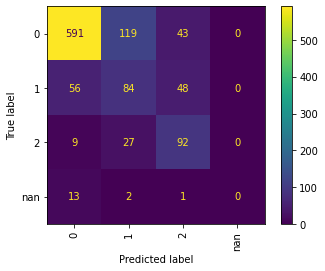

In [37]:
ConfusionMatrixDisplay.from_predictions(is_international_ground_truths.apply(str), pred_international.apply(str))
plt.xticks(rotation=90)
;

In [53]:
def make_binary(x):
  if x is None or pd.isna(x):
    return str(x)
  if str(x) == "nan":
    return str(x)
  return str(min([1,int(x)]))

''

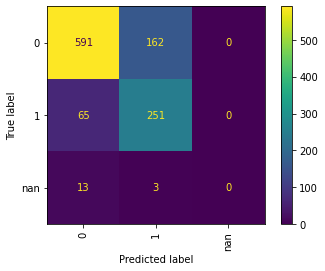

In [54]:
ConfusionMatrixDisplay.from_predictions(is_international_ground_truths.apply(make_binary), pred_international.apply(make_binary))
plt.xticks(rotation=90)
;

In [55]:
acc = accuracy_score(is_international_ground_truths.apply(make_binary), pred_international.apply(make_binary))
print (f"Num countries accuracy {acc}")

Num countries accuracy 0.776036866359447
